**Initialization**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Downloading Libraries and Dependencies**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [34]:
#@ IMPORTING MODULES: UNCOMMENT BELOW:
# !pip install transformers
import torch
import keras
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
import tensorflow as tf
from transformers import pipeline
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup

from tqdm import tqdm, trange
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

#@ IGNORING WARNINGS: 
import warnings
warnings.filterwarnings("ignore")

**Activating GPU**
- Pretraining a multi-head attention transformer model requires the parallel processing GPUs can provide.

In [4]:
#@ ACTIVATING THE GPU:
device_name = tf.test.gpu_device_name()    
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
print("Found GPU at: {}".format(device_name))       # Inspection.

Found GPU at: /device:GPU:0


In [5]:
#@ SPECIFYING CUDA AS DEVICE: 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # Initialization. 
n_gpu = torch.cuda.device_count()                                       # Number of GPUs. 
torch.cuda.get_device_name(0)                                           # Inspection. 

'Tesla T4'

**Loading Dataset**
- We will load CoLA dataset based on Warstadt et al. paper.

In [6]:
#@ LOADING THE DATASET:
path = "/content/drive/MyDrive/Data/in_domain_train.tsv"    # Path to dataset.
df = pd.read_csv(path, delimiter="\t", header=None, 
                 names=["sentence_source", "label",
                        "label_notes", "sentence"])         # Reading dataset.
df.shape                                                    # Inspecting shape.

(8551, 4)

In [7]:
#@ INSPECTING DATASET:
df.sample(5)

,sentence_source,label,label_notes,sentence
8311,ad03,0,*,gilgamesh might loved ishtar
1284,r-67,0,*,tony has a fiat to yearn for a tall nurse .
3043,l-93,1,NaN,ellen told a story .
5851,c_13,1,NaN,you can lead a horse to water but will it drink ?
1721,r-67,0,*,mary and kissed an old friend who comes from m...


**Preprocessing Dataset**

In [8]:
#@ PREPROCESSING THE DATASET: 
sentences = df.sentence.values                                          # Initializing arrays. 
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]  # Adding BERT tokens. 
labels = df.label.values                                                # Initializing arrays. 

**BERT Tokenizer**
- We will initialize a pretrained BERT tokenizer. 

In [10]:
#@ INITIALIZING BERT TOKENIZER:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased",
                                          do_lower_case=True)           # Initializing BERT tokenizer. 
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]      # Initializing tokenization. 
print("Tokenizing first sentence:")
print(tokenized_texts[0])                                               # Inspection. 

Tokenizing first sentence:
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [11]:
#@ PROCESSING THE DATA:
MAX_LEN = 128                                                           # Initialization. 
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in \
             tokenized_texts]                                           # Initializing BERT vocabulary. 
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          truncating="post", padding="post")            # Padding input tokens. 

**Attention Masks**
- We will create the attention masks to prevent the model from performing attention on padded tokens. 

In [12]:
#@ INITIALIZING ATTENTION MASKS: 
attention_masks = []                                # Initialization. 
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]            # Adding mask of 1s and 0s. 
    attention_masks.append(seq_mask)                # Initializing attention masks. 

**Preparing Dataset**

In [13]:
#@ SPLITTING DATA INTO TRAINING AND VALIDATION: 
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, labels, random_state=2022, test_size=0.1)                                # Training and validation dataset. 
train_masks, validation_masks, _, _ = train_test_split(
    attention_masks, input_ids, random_state=2022, test_size=0.1)                       # Training and validation masks. 

In [14]:
#@ CONVERTING DATA INTO TENSORS:
train_inputs = torch.tensor(train_inputs)               # Converting into tensors. 
train_labels = torch.tensor(train_labels)               # Converting into tensors. 
validation_inputs = torch.tensor(validation_inputs)     # Converting into tensors. 
validation_labels = torch.tensor(validation_labels)     # Converting into tensors. 
train_masks = torch.tensor(train_masks)                 # Converting into tensors. 
validation_masks = torch.tensor(validation_masks)       # Converting into tensors. 

In [15]:
#@ SELECTING BATCH SIZE AND CREATING ITERATOR: 
batch_size = 32                                                         # Initializing batch size. 
train_data = TensorDataset(train_inputs, train_masks, train_labels)     # Initializing tensordataset. 
train_sampler = RandomSampler(train_data)                               # Initializing train sampler. 
train_dataloader = DataLoader(train_data, sampler=train_sampler, 
                              batch_size=batch_size)                    # Initializing train dataloader. 
validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)                      # Initializing tensordataset.
validation_sampler = RandomSampler(validation_data)                     # Initializing validation sampler. 
validation_dataloader = DataLoader(validation_data, 
                                   sampler=validation_sampler,
                                   batch_size=batch_size)               # Initializing validation dataloader.

**BERT Model Configuration**
- We will initialize BERT uncased configuration.

In [16]:
#@ BERT MODEL CONFIGURATIONS: 
try:
    import transformers
except:
    print("Installing Transformers")
    !pip install transformers                               # Installing transformers. 
from transformers import BertModel, BertConfig
configuration = BertConfig()                                # Initializing BERT configurations. 
model = BertModel(configuration)                            # Initializing BERT model. 
configuration = model.config                                # Accessing model configuration. 
print(configuration)                                        # Inspecting configuration. 

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [18]:
#@ LOADING HUGGING FACE BERT UNCASED MODEL:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)     # Initializing pretrained model. 
model.cuda()                                                                                 # Inspection. 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

**Optimizer Grouped Parameters**
- We will prepare the model's parameters for the training loop. Fine-tuning a model begins with initializing the pretrained model parameter values. We shouldn't apply weight decay to parameters: bias, gamma, beta. 

In [19]:
#@ OPTIMIZER GROUPED PARAMETERS:
param_optimizer = list(model.named_parameters())                # Initializing model parameters. 
no_decay = ["bias", "LayerNorm.weight"]                         # Initialization. 
optimizer_grouped_parameters = [
    {"params": [p for n, p in param_optimizer if not any(
        nd in n for nd in no_decay
    )], "weight_decay_rate": 0.1},                              # Initializing weight parameters. 
    {"params": [p for n, p in param_optimizer if any(
        nd in n for nd in no_decay
    )], "weight_decay_rate": 0.0}                               # Initializing bias parameters. 
]

**Initializing Hyperparameters**
- The learning rate and warm-up rate should be set to a very small value early in the optimization phase and gradually increase after a certain number of iterations. This avoids large gradients and overshooting the optimization goals. Adam will activate weight decay and also go through a warm-up phase. 

In [29]:
#@ INITIALIZING ADAM OPTIMIZER:
epochs = 4
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5,eps=1e-8)   # Initializing adam optimizer.
total_steps = len(train_dataloader) * epochs                        # Initializing training steps.
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps)  # Initializing learning rate scheduler.

#@ DEFINING ACCURACY MEASUREMENT FUNCTION:
def flat_accuracy(preds, labels):                                   # Accuracy function. 
    pred_flat = np.argmax(preds, axis=1).flatten()                  # Flatten the prediction. 
    labels_flat = labels.flatten()                                  # Flatten the labels. 
    return np.sum(pred_flat == labels_flat) / len(labels_flat)      # Measuring accuracy. 

In [30]:
#@ INITIALIZING TRAINING LOOP:
train_loss = []                                                             # Initialization.
for _ in trange(epochs, desc="Epoch"):
    #@ TRAINING:
    model.train()                                                           # Initializing training mode. 
    tr_loss = 0                                                             # Initialization. 
    nb_tr_examples, nb_tr_steps = 0, 0                                      # Initialization.
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)                          # Adding batch to GPU.
        b_input_ids, b_input_masks, b_labels = batch      
        optimizer.zero_grad()                                               # Zeroing gradients.
        output = model(b_input_ids, token_type_ids=None, 
                       attention_mask=b_input_masks,labels=b_labels)        # Forward propagation function.
        loss = output["loss"]                                               # Getting loss. 
        train_loss.append(loss.item())                                      # Accumulating losses. 
        loss.backward()                                                     # Back propagation function. 
        optimizer.step()                                                    # Updating parameters.
        tr_loss += loss.item()                                              # Updating loss.
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    print("Train loss: {}".format(tr_loss / nb_tr_steps))                   # Getting training loss. 
    #@ VALIDATION:
    model.eval()                                                            # Initializing evaluation mode. 
    eval_loss, eval_accuracy = 0, 0                                         # Initialization.
    nb_eval_steps, nb_eval_examples = 0, 0                                  # Tracking variables. 
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)                          # Adding batch to GPU.
        b_input_ids, b_input_masks, b_labels = batch                
        with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, 
                           attention_mask=b_input_masks)
        logits = logits["logits"].detach().cpu().numpy()                    # Moving to CPU.
        label_ids = b_labels.to("cpu").numpy()                              # Moving to CPU.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)                # Calculating accuracy.
        eval_accuracy += tmp_eval_accuracy                                  # Updating.
        nb_eval_steps += 1 
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))    # Getting validation accuracy.

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.4975795211633706


Epoch:  25%|██▌       | 1/4 [02:41<08:03, 161.07s/it]

Validation Accuracy: 0.8344907407407407
Train loss: 0.3005098934242834


Epoch:  50%|█████     | 2/4 [05:33<05:35, 167.68s/it]

Validation Accuracy: 0.8321759259259259
Train loss: 0.17634920581124136


Epoch:  75%|███████▌  | 3/4 [08:25<02:49, 169.74s/it]

Validation Accuracy: 0.8491512345679012
Train loss: 0.10905328953321791


Epoch: 100%|██████████| 4/4 [11:17<00:00, 169.44s/it]

Validation Accuracy: 0.8329475308641975


**Training Evaluation**
- The loss and accuracy values were stored. 

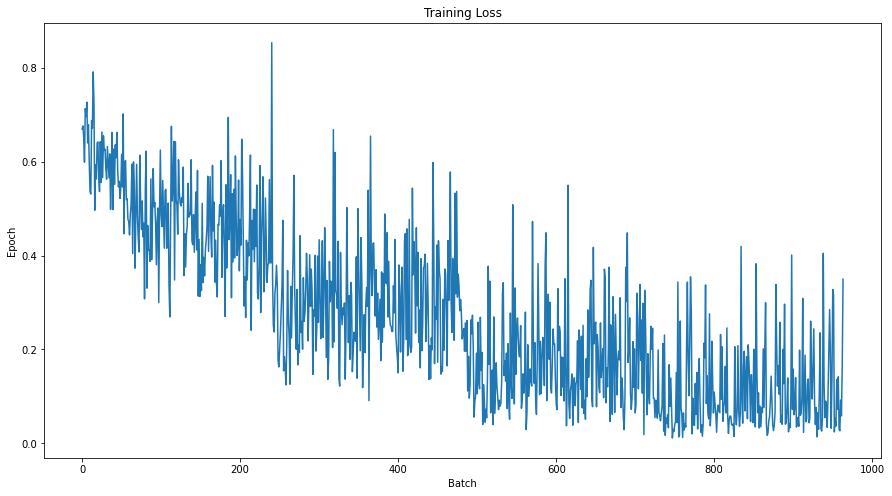

In [31]:
#@ INITIALIZING TRAINING EVALUATION: 
plt.figure(figsize=(15, 8))
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Epoch")
plt.plot(train_loss)
plt.show();

In [32]:
#@ INITIALIZING MODEL EVALUATION:
PATH = "/content/drive/MyDrive/Data/out_of_domain_dev.tsv"                          # Path to dataset.
df = pd.read_csv(PATH, delimiter="\t", header=None, 
                 names=["sentence_source", "label", "label_notes", "sentence"])     # Reading the dataset.

#@ PREPROCESSING THE DATASET: 
sentences = df.sentence.values                                          # Initializing arrays. 
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]  # Adding BERT tokens. 
labels = df.label.values                                                # Initializing arrays. 

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]      # Initializing tokenization. 

#@ PROCESSING THE DATA:
MAX_LEN = 128                                                           # Initialization. 
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in \
             tokenized_texts]                                           # Initializing BERT vocabulary. 
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          truncating="post", padding="post")            # Padding input tokens. 

#@ INITIALIZING ATTENTION MASKS: 
attention_masks = []                                # Initialization. 
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]            # Adding mask of 1s and 0s. 
    attention_masks.append(seq_mask)                # Initializing attention masks. 

#@ CONVERTING DATA INTO TENSORS:
prediction_inputs = torch.tensor(input_ids)         # Converting into tensors. 
prediction_labels = torch.tensor(labels)            # Converting into tensors. 
prediction_masks = torch.tensor(attention_masks)    # Converting into tensors. 

#@ SELECTING BATCH SIZE AND CREATING ITERATOR: 
batch_size = 32                                                                             # Initializing batch size. 
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)     # Initializing tensordataset. 
prediction_sampler = RandomSampler(prediction_data)                                         # Initializing prediction sampler. 
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, 
                                   batch_size=batch_size)                                   # Initializing train dataloader. 

In [33]:
#@ INITIALIZING PREDICTION:
model.eval()                                                            # Initializing evaluation mode. 
predictions, true_labels = [], []                                       # Initialization.
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)                          # Adding batch to GPU.
    b_input_ids, b_input_masks, b_labels = batch                
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, 
                       attention_mask=b_input_masks)
    logits = logits["logits"].detach().cpu().numpy()                    # Moving to CPU.
    label_ids = b_labels.to("cpu").numpy()                              # Moving to CPU.
    predictions.append(logits)
    true_labels.append(label_ids)

In [35]:
#@ EVALUATING MATTHEWS CORRELATION COEFFICIENT:
matthews_set = []                                                       # Initialization.
for i in range(len(true_labels)):
    matthews = matthews_corrcoef(
        true_labels[i], np.argmax(predictions[i], axis=1).flatten())    # Matthews correlation coefficient.
    matthews_set.append(matthews)                                       # Accumulating MCC.
matthews_set                                                            # Inspction.

[0.8246211251235321,
 0.3768673314407159,
 0.26857142857142857,
 0.5269860393922079,
 0.17338428937260214,
 0.4472135954999579,
 0.7006490497453707,
 0.32660542964119055,
 0.49517597397212765,
 0.24444444444444444,
 0.6777749493656265,
 0.539791896359413,
 0.6908212560386473,
 0.5807564950208268,
 0.6217695735539032,
 0.539791896359413,
 0.5773502691896258]

In [38]:
#@ INSPECTING MATTHEWS CORRELATION COEFFICIENT: 
flat_predictions = [item for sublist in predictions for item in sublist]        # Initializing predictions. 
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()                # Flatten predictions. 
flat_true_labels = [item for sublist in true_labels for item in sublist]        # Initializing true labels.
matthews_corrcoef(flat_true_labels, flat_predictions)                           # Getting MCC score.

0.5194752376551192